# Datasets Desbalanceados

## 1. Datasets Sintéticos

Vamos a comenzar generando un dataset sintético. La ventaja de este enfoque es que podemos controlar muchas características de este dataset. Por ejemplo, la cantidad de features, si hay features correlacionados o no, la separación entre clases, el desbalanceo, etc.

Vamos a comenzar generando un dataset, que luego separaremos en un dataset medido y en un dataset no medido. De esta forma, simulamos (de una manera muy inocente) el proceso de medición. Esto se podría hacer mejor: en este proceso de medición podríamos agregar ruido, valores mal medidos, etiquetas intercambiadas, etc.

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.datasets import make_classification

La siguiente celda genera los datos con los que vamos a trabajar. 

In [75]:
X_real, y_real = make_classification(n_samples=100000,n_features=4, n_informative=4,
                                     n_redundant=0, n_clusters_per_class=1,
                                     class_sep=1.0, weights = [0.99], random_state=40)

Y miramos la cantidad de instancias con etiqueta positiva y qué porcentaje del dataset representa.

In [76]:
print(y_real.sum())
print(y_real.sum()/y_real.size)

1470
0.0147


Pasamos a un DataFrame de Pandas para poder aprovechar algunas funcionalidades de la librería.

In [77]:
df_real = pd.DataFrame()

In [78]:
for i in range(X_real.shape[1]):
    df_real['x' + str(i)] = X_real[:,i]
df_real['y'] = y_real  


Como ya viene mezclado al azar, seleccionar las diez mil primeras instancias es equivalente a muestrear al azar el dataset original.

In [79]:
N = 10000
df_medido = df_real[:N]
df_medido.head()

,x0,x1,x2,x3,y
0,3.976821,0.372961,-0.650739,2.073284,0
1,1.629085,-1.059597,-1.654043,0.431430,0
2,1.178563,-0.250376,2.329269,1.370564,0
3,1.093868,-1.616160,1.727165,1.464183,0
4,-0.652038,-2.527268,1.589253,1.248053,0


Y dejamos el resto de los los datos como instancias 'no medidas'.

In [80]:
df_no_medido = df_real[N:].reset_index(drop = True)
df_no_medido.head()

,x0,x1,x2,x3,y
0,0.482545,-0.448791,-0.812647,0.595696,0
1,5.544468,-1.917801,0.870708,3.020132,0
2,2.154670,-1.124450,0.215696,1.889750,0
3,2.290953,-0.976496,0.518059,1.531779,0
4,3.191610,-0.883649,1.206954,2.068909,0


¿Cuántas instancias positivas y qué porcentaje hay en cada dataset?

In [81]:
print(df_medido.y.sum())
print(df_medido.y.sum()/df_medido.size)

print(df_no_medido.y.sum())
print(df_no_medido.y.sum()/df_no_medido.size)

162
0.00324
1308
0.0029066666666666668


### Exploración de los datos

Miremos cómo es el dataset con el que vamos a trabajar, `df_medido`.

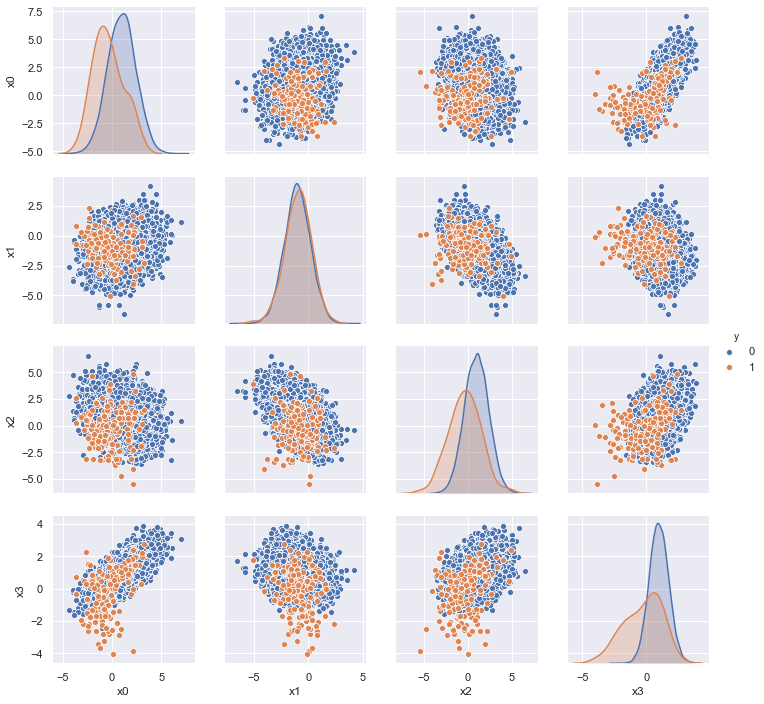

In [82]:
sns.pairplot(data = df_medido, vars = df_medido.columns[:-1], hue = 'y')

Y cómo queda la tabla de correlaciones.

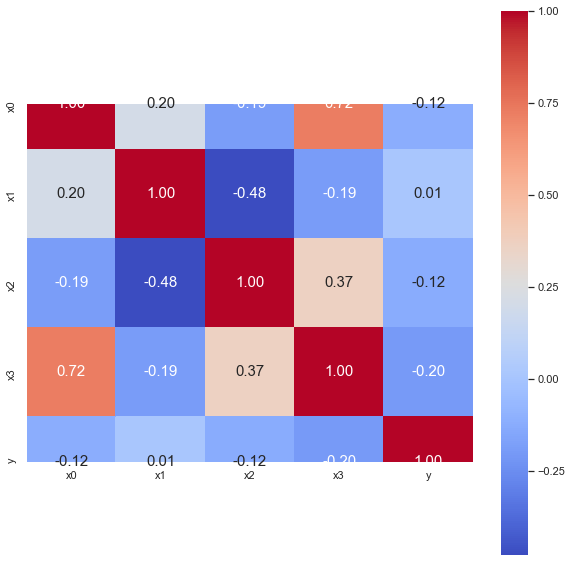

In [83]:
corr = df_medido.corr('pearson')
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df_medido.columns, 
           yticklabels= df_medido.columns,
           cmap= 'coolwarm')
# plt.xticks(rotation = 45)
# plt.yticks(rotation = 45)
plt.show()

¿Cuáles atributos serán buenos predictores?

**Ejercicio:** Familiarizarse con la función que genera los datos. Cambiar algunos de sus parámetros y volver a correr. 

**Para pensar**: ¿Qué pasa con la tabla de correlaciones a medida que la prevalencia de la clase positiva disminuye?

## 2. Entrenamiento Modelo Uno

Vamos a entrenar un primer modelo de árbol de decisión y evaluarlo usando exactitud. Para ello:

Seleccionamos variables predictoras y etiquetas

In [84]:
X = df_medido.drop('y', axis = 1).values
y = df_medido.y.values

Hacemos un `train_test_split`

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify = y)

Observamos cómo son las distribuciones de las variables predictoras

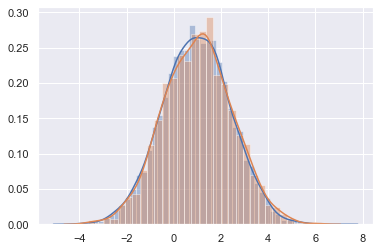

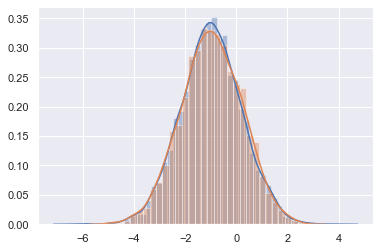

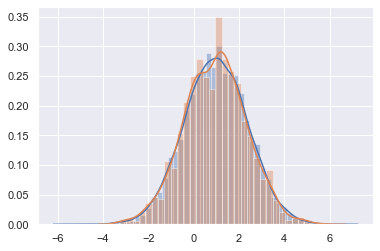

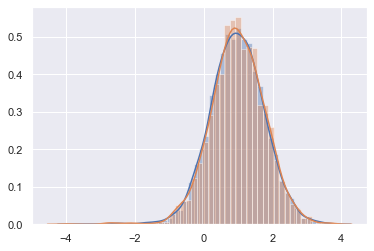

In [86]:
for i in range(X_train.shape[1]):
    sns.distplot(X_train[:,i])
    sns.distplot(X_test[:,i])
    plt.show()

Y la proporción de etiquetas positivas en los datos de train y test.

In [87]:
print('Proporcion de etiquetas positiva en los datos de Train: ', y_train.sum()/y_train.size)
print('Proporcion de etiquetas positiva en los datos de Test: ', y_test.sum()/y_test.size)

Proporcion de etiquetas positiva en los datos de Train:  0.01625
Proporcion de etiquetas positiva en los datos de Test:  0.016


### Entrenamiento del modelo

Vamos a hacer una curva de validación para elegir la mejor profundidad para el árbol de decisión. 

In [88]:
from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

In [89]:
from sklearn.model_selection import cross_validate

tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,50,1)

for profundidad in profundidades:
    clf = DecisionTreeClassifier(max_depth=profundidad, random_state=42)
    tree_scores = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

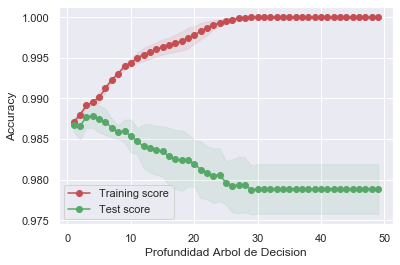

In [90]:
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

¿Cuál profundidad usarían? ¿Cuál es el *benchmark* de este problema?

Entrenemos un árbol de profundidad tres y evaluémoslo en el conjunto de test.

In [92]:
clf_1 = DecisionTreeClassifier(max_depth = 3, random_state = 42)
clf_1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [93]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = clf_1.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = clf_1.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.989125
Accuracy sobre conjunto de Test: 0.9875


¿Es un buen modelo? Veamos la matriz de confusión en cada conjunto.

In [94]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)


array([[7867,    3],
       [  84,   46]], dtype=int64)

In [95]:
confusion_matrix(y_test, y_test_pred)


array([[1966,    2],
       [  23,    9]], dtype=int64)

¿Cuáles son sus aciertos, Falsos Positivos y Falsos Negativos?¿Es lo mismo si nos interesa la clase 0 que la clase 1? En el caso de un examen médico, ¿un FP tiene el mismo costo que un FN?

**Ejercicio:** calcular la precisión, exhaustividad (recall) y F-Score de este modelo para cada clase sobre el conjunto de Test. Pueden hacerlo a partir de la matriz de confusión o usando funciones que ya están incorporadas en Scikit-Learn.

### ¿Y si lo ponemos "en producción"?

Una de las ventajas de trabajar con datos sintéticos es que podemos ver cómo desempeñaría nuestro modelo si lo ponemos en producción.

In [96]:
X_no_medido = df_no_medido.drop('y', axis = 1).values
y_no_medido = df_no_medido.y.values

In [97]:
# Predecimos sobre todas las instancias que no vio
y_no_medido_pred = clf_1.predict(X_no_medido)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_no_medido_pred,y_no_medido_pred))

Accuracy sobre conjunto de Train: 1.0


In [98]:
confusion_matrix(y_no_medido, y_no_medido_pred)

array([[88556,   136],
       [  880,   428]], dtype=int64)

**Ejercicio:** medir precisión, exhaustividad y F-Score

In [99]:
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support

print(precision_score(y_no_medido, y_no_medido_pred, average=None))

print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average=None))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='macro'))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='micro'))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='weighted'))



[0.99016056 0.75886525]
(array([0.99016056, 0.75886525]), array([0.9984666 , 0.32721713]), array([0.99429624, 0.45726496]), array([88692,  1308], dtype=int64))
(0.8745129049847127, 0.6628418644545375, 0.7257805968396106, None)
(0.9887111111111111, 0.9887111111111111, 0.9887111111111111, None)
(0.986799069852716, 0.9887111111111111, 0.9864913818239607, None)


**Ejercicio:** repetir para un modelo de vecinos más cercanos.

## 3. Balanceando el Dataset

Vamos a balancear el dataset subsampleando la clase más prevalente. Luego, volvemos a analizar los datos y entrenar los modelos.

In [100]:
mask = df_medido.y == 1

df_subsample = pd.concat([df_medido[mask], df_medido[~mask].sample(n = mask.sum())])

In [101]:
df_subsample = df_subsample.sample(frac=1,  random_state=42).reset_index(drop=True)

Hacemos el `pairplot`

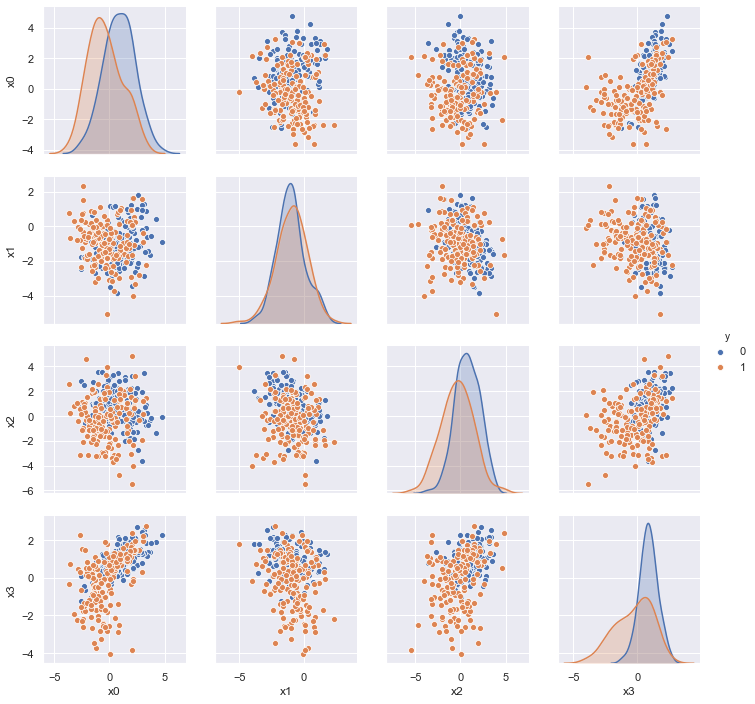

In [102]:
sns.pairplot(data = df_subsample, vars = df_subsample.columns[:-1], hue = 'y')

Y la tabla de correlaciones.

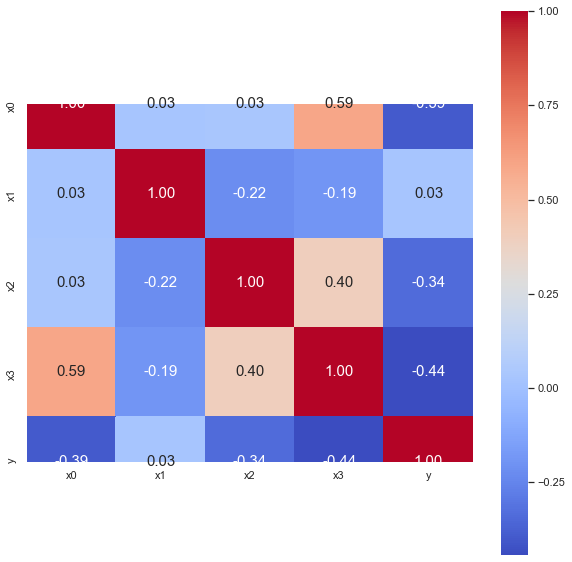

In [103]:
corr = df_subsample.corr('pearson')
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df_subsample.columns, 
           yticklabels= df_subsample.columns,
           cmap= 'coolwarm')
# plt.xticks(rotation = 45)
# plt.yticks(rotation = 45)
plt.show()

¿Notan algo diferente en la tabla con respecto a la anterior? Si quieren, copien la celda de código de la tabla anterior para poder verlas juntas.

## 4. Entrenamiento Modelo Dos

Seleccionamos variables predictoras y etiquetas

In [104]:
X = df_subsample.drop('y', axis = 1).values
y = df_subsample.y.values

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify = y)

Observamos cómo son las distribuciones de las variables predictoras

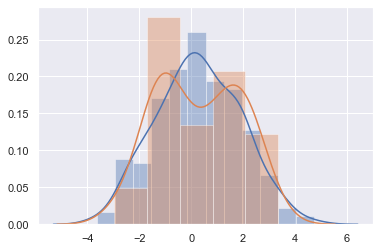

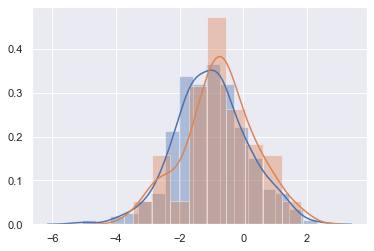

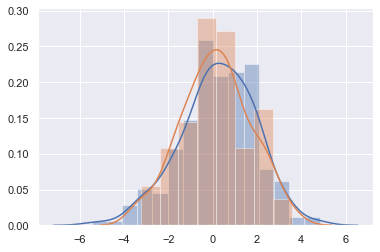

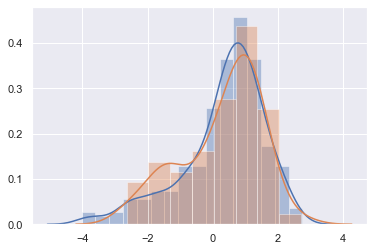

In [106]:
for i in range(X_train.shape[1]):
    sns.distplot(X_train[:,i])
    sns.distplot(X_test[:,i])
    plt.show()

Y la proporción de etiquetas positivas en los datos de train y test.

In [107]:
print('Proporcion de etiquetas positiva en los datos de Train: ', y_train.sum()/y_train.size)
print('Proporcion de etiquetas positiva en los datos de Test: ', y_test.sum()/y_test.size)

Proporcion de etiquetas positiva en los datos de Train:  0.4980694980694981
Proporcion de etiquetas positiva en los datos de Test:  0.5076923076923077


### Entrenamiento del modelo

Volvemos a hacer la curva de validación.

In [108]:
tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,50,1)

for profundidad in profundidades:
    clf = DecisionTreeClassifier(max_depth=profundidad, random_state=42)
    tree_scores = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

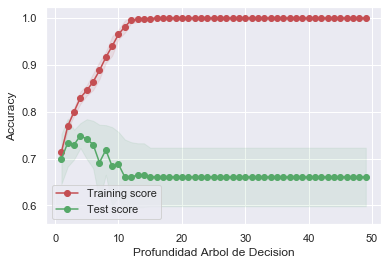

In [109]:
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")


plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

¿Cuál profunidad usarían? Cuál es el *benchmark* de este problema?

Entrenemos un árbol de profundidad tres y evaluémoslo en el conjunto de test.

In [110]:
clf_2 = DecisionTreeClassifier(max_depth = 3, random_state = 42)
clf_2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [111]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = clf_2.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = clf_2.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.7915057915057915
Accuracy sobre conjunto de Test: 0.7692307692307693


¿Es un buen modelo? Veamos la matriz de confusión en cada conjunto.

In [112]:
confusion_matrix(y_train, y_train_pred)

array([[124,   6],
       [ 48,  81]], dtype=int64)

In [113]:
confusion_matrix(y_test, y_test_pred)

array([[29,  3],
       [12, 21]], dtype=int64)

¿Cuáles son sus aciertos, Falsos Positivos y Falsos Negativos?¿Es lo mismo si nos interesa la clase 0 que la clase 1? 

**Ejercicio:** Igual que antes. Calcular la precisión, exhaustividad (recall) y F-Score de este modelo para cada clase sobre el conjunto de Test. Pueden hacerlo a partir de la matriz de confusión o usando funciones que ya están incorporadas en Scikit-Learn.

### ¿Y si lo ponemos "en producción"?

In [114]:
X_no_medido = df_no_medido.drop('y', axis = 1).values
y_no_medido = df_no_medido.y.values

In [115]:
# Predecimos sobre todas las instancias que no vio
y_no_medido_pred = clf_2.predict(X_no_medido)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_no_medido_pred,y_no_medido))

Accuracy sobre conjunto de Train: 0.9308


In [116]:
confusion_matrix(y_no_medido, y_no_medido_pred)

array([[83046,  5646],
       [  582,   726]], dtype=int64)

¿Qué cambió?¿Es mejor o peor este modelo que el anterior árbol de decisión?

**Ejercicio:** medir precisión, exhaustividad y F-Score

In [117]:
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_no_medido,y_no_medido_pred,average='macro'))
print(precision_recall_fscore_support(y_no_medido,y_no_medido_pred,average='micro'))
print(precision_recall_fscore_support(y_no_medido,y_no_medido_pred,average='weighted'))

(0.5534882891384201, 0.7456936839870956, 0.5764602193593314, None)
(0.9308, 0.9308, 0.9308, None)
(0.9802642876618785, 0.9308, 0.9525975783426182, None)


**Ejercicio:** repetir para un modelo de vecinos más cercanos.

In [118]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [119]:
clf_1 = DecisionTreeClassifier(max_depth = 3, random_state = 42)
clf_1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

## 5. Dataset de Fraude

Los invitamos a trabajar con este dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud

Pueden encontrar un link a un lindo análisis en la presentación de la clase de hoy.

## 6. Curva ROC


In [126]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [127]:
def plot_roc_curve(fpr, tpr) :
    plt.rcParams["figure.figsize"] = (18,8)
    plt.plot(fpr, tpr, color = 'orange', label = 'ROC')
    Plt.plot([0,1], [0,1], color='darkblue', linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [122]:
clf_1 = DecisionTreeClassifier(max_depth = 3, random_state = 42)
clf_1.fit (X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [123]:
probs = clf_1.predict_proba(X_test)
probs

array([[0.        , 1.        ],
       [0.74666667, 0.25333333],
       [0.74666667, 0.25333333],
       [0.74666667, 0.25333333],
       [0.30769231, 0.69230769],
       [0.74666667, 0.25333333],
       [0.        , 1.        ],
       [0.74666667, 0.25333333],
       [0.74666667, 0.25333333],
       [0.        , 1.        ],
       [0.74666667, 0.25333333],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06666667, 0.93333333],
       [0.74666667, 0.25333333],
       [0.74666667, 0.25333333],
       [0.74666667, 0.25333333],
       [0.74666667, 0.25333333],
       [0.74666667, 0.25333333],
       [0.74666667, 0.25333333],
       [0.06666667, 0.93333333],
       [0.74666667, 0.25333333],
       [0.74666667, 0.25333333],
       [0.        , 1.        ],
       [0.52380952, 0.47619048],
       [0.74666667, 0.25333333],
       [0.74666667, 0.25333333],
       [0.30769231, 0.69230769],
       [0.30769231, 0.69230769],
       [0.74666667, 0.25333333],
       [0.

In [124]:
probs = probs[:1]
probs

array([[0., 1.]])

In [125]:
auc = roc_auc_score(y_test,probs)
print('AUC: %.2f' % auc)

ValueError: Found input variables with inconsistent numbers of samples: [65, 1]

In [58]:
fpr, tpr, _ = roc_curve(y_test, probs)

NameError: name 'probs' is not defined

In [ ]:
fpr

In [ ]:
plot_roc_curve(fpr, tpr)